## Reading and analysis of NorESM CAM diagnostics files

This notebook provides an interface to read, structure and analyse CAM diagnostics files (see e.g. [here](https://github.com/jgliss/my_notebooks/blob/master/data/from_ada/table_GLBL_ANN_obs.asc)) in order to highlight performance of the model runs with respect to each other, relative to observation data.

### Short summary of what this notebook does

In this notebook, a number of CAM diagnostics files is imported and put into one large table (in the following denoted as \\(\mathcal{T}\\)). This table is modified and reshaped in order to create heatmap plots of different variables (e.g. Bias, RMSE) for a set of predefined variables (e.g. fluxes) that are aimed to provide an intuitive display of model performance between individual runs.

#### Result file structure

The tables in each file contain the following \\(K=4\\) data columns (in the specified order):

1. Model value
2. Observation value
3. Bias (1. - 2.)
4. RMSE

and a total of \\(M=63\\) rows for each of the diagnostics variables (e.g. RESTOM, RESSURF, ..., Z3_500_NCEP).

#### Goal / Purpose / Steps

1. **Read**: Read \\(N\\) CAM diagnostics files (one for each of \\(N\\) model runs), each of which contains \\(M=63\\) variables (rows). 
2. **Merge** the individual tables for each file into a single long table. This results in a long table with a total of \\(N\cdot M\\) rows and \\(K=4\\) data columns (Model value, Obs value, Bias, RMSE, see above). Shape of \\(\mathcal{T} = (N\cdot M) \times K\\)
3. **Compute and add column to \\(\mathcal{T}\\)**: in current version the typical RMSE error is computed and added. New shape of \\(\mathcal{T} = (N\cdot M) \times (K+1)\\)
4. **Reduce variable dimensionality**: Select a group of \\(m\\) variables (where \\(m<M\\)) that you are interested in (e.g. fluxes). New shape of \\(\mathcal{T} = (N\cdot m) \times (K+1)\\)
5. Define \\(k\\) data columns, that you are interested in (e.g. Bias, RMSE).
4. For each of the \\(k\\) columns do the following:

    4.1. **Extract column** \\(k\\) from \\(\mathcal{T}\\). Results in sub-table of shape \\(\mathcal{T_{sub}}(k) = (N\cdot m) \times 1\\). 
    
    ***NOTE***: this is a very long table (e.g. if you are interested in \\(m=10\\) variables and \\(N=20\\) model runs, you will end up with ***200*** rows and a single column) ***with only only 1 column*** . Thus, the sub-tables for each of the \\(k\\) columns will be rearranged into a more by adding parts of the index (rows) into a column representation. For instance, you can rearrange each \\(\mathcal{T_{sub}}(k)\\) such, that the variables of your group remain in a row representation but the individual runs are *unstacked* into a column representation, making the table wider (e.g. shape of \\(\mathcal{T_{sub}} = (N\cdot m) \times 1 \rightarrow N \times m\\), hence, resulting in a more rectangular shape of the sub-table that can then be plotted as a heatmap.
    
    4.2. **Plot and save heatmap**: in the final step, each of the rearranged sub-tables for the \\(k\\) columns of interest will be plotted as heatmap and stored as image or vector file. 

#### Import of multiple files

The files are read subsequently and put into a long table that contains an hierarchical index ([see here for details](https://pandas.pydata.org/pandas-docs/stable/advanced.html)) in the order:

1. Run ID (e.g. N1850_f19_tn14_r227_ctrl)
2. Years of run (e.g. yrs 310-340)
3. Variable ID
4. Variable description 

\* note that 3. and 4. are linked to each other (i.e. 4. is irrelevant for the index but is included for display purposes, i.e. to have a short info about the variable in the display, next to the variable ID).

#### Execution of notebook

1. Please follow the instructions in Sect. 1 and update were necessary
2. Everything from Sect. 2. should run through and you should find the output figures in the output directory that you specify in Sect. 1.1.

Starting with some relevant imports

In [1]:
import helper_funcs as helpers #helper functions (helper_funcs.py)
from glob import glob #for file search
import os

### 1. Paths and global settings (GLOB)  

Please change accordingly if you execute this notebook on your local machine.

#### 1.1. Paths (PATHS)

Here you can specify your paths.

In [2]:
#folder with ascii files
DATA_DIR = "./example_data/"
FILE_TYPE = "webarchive" #csv

# file containing additional information about variables (long names, can be interactively updated below)
VARINFO_CSV = "./config/var_info.csv"

# Config file for different groups
VARGROUPS_CFG = "./config/var_groups.ini"

#directy to store results
OUTPUT_DIR = "./output/"

# make sure output direcory exists
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

#### 1.2. Plot settings (PLOT_SETUP)

Specify anything related to the final heatmap plots

In [3]:
# figure size in inches and aspect ratio of heatmap plots, 
# might need to be adjusted dependent on number of runs, selected variables and table reshape settings
FIG_SIZE = (12, 6) 

#### 1.3 Table settings and definition of variables (SETUP)

In the following cells you can specify global default settings.

##### 1.3.1 Define group of variables that you are interested in

Default group of variables. Variable groups can be defined in supplementary file *var_groups.ini* (in *config* sub-directory of repo). Use ``[group_name]`` to define a new group and add below all variables that should belong to the group in the desired display order (should be self-explanatory when looking at the file, I hope).

In [4]:
VAR_GROUP = "fluxes" #group_name (AS STRING, e.g. "test") from varconfig.ini (use None, if you want to use all)

##### 1.3.2 (OPTIONAL): Add data columns to index

Use the following list to specify table columns that should be added to the multiindex (e.g. "Obs").

In [5]:
ADD_TO_INDEX = ["Obs"] #NEEDS TO BE A LIST, EVEN FOR ONLY ONE ITEM

##### 1.3.3 Define which parts of index should be arranged in a column representation (unstacking)

The following list can be used to specify how the final lists are displayed. The items in the list need to be names of sub-indices in the the Multiindex of the originally loaded file (i.e. "Run", "Years", "Variable", "Description") or data columns that were added to index (previous option). 

All values specified here will be unstacked, i.e. put from the original row into a column index representation (makes table view wider).

In [6]:
UNSTACK_INDICES = ["Run", "Years"]

##### 1.2.4 (OPTIONAL) Define index levels used for computing statistics (i.e. RMSE relative error)

Specify list of index level names of the original index that are used to compute the mean RMSE. 

Default is

    ["Run", "Years"]
    
meaning that the average RMSE for each variable will be computed based on the set of values retrieved from all files.

In [7]:
RMSE_STATS = ["Run", "Years"]

### 2. Importing and editing supplementary information

Let's begin with reading additional variable information from the file *var_info.csv*. Note that this is not strictly required but helps us below to display the results in a more intuitive manner, when visualising the data.

In [8]:
VAR_INFO_DICT = helpers.load_varinfo(VARINFO_CSV)

The following cell opens an interactive widget that can be used to edit the information available for each variable (stored in file ``varinfo_csv``, see previous cell).

### 3. Search and load ASCII files, either using .asc or .webarchive file type (GET_FILES)

The following cell finds all files in folder ``data_dir``.

In [9]:
FILES = sorted(glob(DATA_DIR + "*.{}".format(FILE_TYPE)))

Print all file names:

In [10]:
for file in FILES:
    print(file)    

./example_data/N1850C53CLM45L32_f09_tn11_191017 (yrs 71-100).webarchive
./example_data/N1850_f09_tn14_230218 (yrs 1-20).webarchive
./example_data/N1850_f19_tn14_r227_ctrl (yrs 185-215).webarchive
./example_data/N1850_f19_tn14_r227_ctrl (yrs 310-340).webarchive
./example_data/N1850_f19_tn14_r227_ctrl (yrs 80-110).webarchive
./example_data/N1850_f19_tn14_r265_ctrl_20180411 (yrs 90-120).webarchive


You can see that the names of the files are quite long and this may impact the labelling of the heatmap plots below (and of the table displays in this notebook). Therefore, you have the option, to apply a renaming to each of the runs in the following cell. 

##### 3.1 Shortcuts for Run IDs (OPTIONAL)

Define list of shortnames for model runs or define a prefix. If undefined (i.e. empty list and ``None``), the original names are used. By default, the runs will be renamed using a prefix "Run" and the number of the file in the list.

**<span style="color:red">NOTE</span>**: when reading the files, the file IDs (e.g. *N1850_f19_tn14_r227_ctrl (yrs 185-215)* or *N1850_f19_tn14_r227_ctrl (yrs 80-110)*) are split into a ***run_id*** (e.g. *N1850_f19_tn14_r227_ctrl*) and a string representing the years of the model run (e.g. *(yrs 80-110)*). These make up to individual levels *Run* and *Years* in the hierarchical index of the table \\(\mathcal{T}\\). For instance the 6 files above of the example dataset actually only correspond to 4 unique run IDs, since *N1850_f19_tn14_r227_ctrl* occurs 3 times (for different years).

**<span style="color:red">THUS:</span>** If you want to rename the individual runs below, using the option ``RUN_IDS`` please make sure that the list contains the number of elements that correspond to the number of *unique* run IDs in the file list (i.e. for the example above 4 renaming strings, not 6).

In [11]:
# either
RUN_IDS = ['first', 'second', 'second_last', 'last'] 
# or (is ignored if RUN_IDS is specified)
RUN_ID_PREFIX = "Run"

### 4. Importing multiple result files and concatenating them into one Dataframe (LOAD_FILES)

In the following, we load all files into one large table \\(\mathcal{T}\\) (instance of `pandas.DataFrame`).

To do this, a custom method `read_and_merge_all` was defined in [helper_funcs.py](https://github.com/jgliss/my_py3_scripts/blob/master/notebooks/helper_funcs.py). The method basically loops over all files and calls the method ``read_file_custom``, which you can also find in [helper_funcs.py](https://github.com/jgliss/my_py3_scripts/blob/master/notebooks/helper_funcs.py). 

In [12]:
table = helpers.read_and_merge_all(file_list=FILES, 
                                   var_info_dict=VAR_INFO_DICT, 
                                   replace_runid_prefix=RUN_ID_PREFIX)

# display the table
table

Flag     Model  \
Run  Years  Variable           Description                                  
Run1 71-100 RESTOM             Top model net flux           1.0    -0.489   
            RESSURF            SRF net flux                 1.0    -0.489   
            RESTOA_CERES-EBAF  TOA  net flux                1.0     1.529   
            RESTOA_ERBE        TOA  net flux                1.0     1.529   
            SOLIN_CERES-EBAF   Insolation                   1.0   340.206   
            SOLIN_CERES        Insolation                   1.0   340.206   
            CLDTOT_ISCCP       Total cloud cover            1.0    63.621   
            CLDTOT_CLOUDSAT    Total cloud cover            1.0    63.621   
            FLDS_ISCCP         LW down SRF                  1.0   338.280   
            FLNS_ISCCP         LW net SRF                   1.0    55.819   
            FLUT_CERES-EBAF    LW up Top                    1.0   238.148   
            FLUT_CERES         LW up Top                    1.0   238.148   
            FLUT_ERBE          LW up Top                    1.0   238.148   
            FLUTC_CERES-EBAF   LW up Top Clearsky           1.0   261.783   
            FLUTC_CERES        LW up Top Clearsky           1.0   261.783   
            FLUTC_ERBE         LW up Top Clearsky           1.0   261.783   
            FLNT_CAM           LW net Top                   1.0   236.838   
            FSDS_ISCCP         SW down SRF                  1.0   187.801   
            FSNS_ISCCP         SW net SRF                   1.0   163.679   
            FSNS_LARYEA        SW net SRF                   1.0   163.679   
            FSNTOA_CERES-EBAF                               0.0   239.677   
            FSNTOA_CERES       SW net TOA                   1.0   239.677   
            FSNTOA_ERBE        SW net TOA                   1.0   239.677   
            FSNTOAC_CERES-EBAF                              0.0   287.999   
            FSNTOAC_CERES      SW net TOA clearsky          1.0   287.999   
            FSNTOAC_ERBE       SW net TOA clearsky          1.0   287.999   
            FSNT_CAM           SW net Top                   1.0   236.348   
            LHFLX_JRA25        Lat Heat Flux                1.0    87.904   
            LHFLX_ERA40        Lat Heat Flux                1.0    87.904   
            LHFLX_WHOI         Lat Heat Flux                1.0    87.904   
...                                                         ...       ...   
Run4 90-120 PRECT_GPCP         Precipitation                1.0     2.918   
            PREH2O_NVAP        Precipitable water           1.0    25.733   
            PREH2O_AIRS        Precipitable water           1.0    25.733   
            PREH2O_JRA25       Precipitable water           1.0    25.733   
            PREH2O_ERAI        Precipitable water           1.0    25.733   
            PREH2O_ERA40       Precipitable water           1.0    25.733   
            PSL_JRA25          SeaLev pressure              1.0  1011.614   
            PSL_ERAI           SeaLev pressure              1.0  1011.614   
            SHFLX_JRA25        Sens Heat Flux               1.0    22.229   
            SHFLX_NCEP         Sens Heat Flux               1.0    22.229   
            SHFLX_LARYEA       Sens Heat Flux               1.0    22.229   
            STRESS_MAG_ERS                                  0.0     0.063   
            STRESS_MAG_LARYEA                               0.0     0.063   
            STRESS_MAG_JRA25                                0.0     0.063   
            SWCF_CERES-EBAF    SW Cloud Forc                1.0   -48.959   
            SWCF_CERES         SW Cloud Forc                1.0   -48.959   
            SWCF_ERBE          SW Cloud Forc                1.0   -48.959   
            AODVIS             aerosol optical depth        1.0       NaN   
            AODDUST            dust aerosol optical depth   1.0       NaN   
            SST_HADISST        Sea Srf Temp            

In [13]:
# drop Flag column (is leftover from previous version)
table = table.drop(columns=["Flag"])
table.head()

Model      Obs   Bias  \
Run  Years  Variable          Description                                   
Run1 71-100 RESTOM            Top model net flux   -0.489    0.000 -0.489   
            RESSURF           SRF net flux         -0.489    0.000 -0.489   
            RESTOA_CERES-EBAF TOA  net flux         1.529    0.992  0.537   
            RESTOA_ERBE       TOA  net flux         1.529    0.059  1.470   
            SOLIN_CERES-EBAF  Insolation          340.206  340.054  0.152   

                                                   RMSE  
Run  Years  Variable          Description                
Run1 71-100 RESTOM            Top model net flux    NaN  
            RESSURF           SRF net flux          NaN  
            RESTOA_CERES-EBAF TOA  net flux       8.842  
            RESTOA_ERBE       TOA  net flux       8.992  
            SOLIN_CERES-EBAF  Insolation          0.167

#### 4.1. Applying renaming of run IDs (if applicable)

In [14]:
if RUN_IDS is not None:
    table = helpers.rename_index_dataframe(table, level="Run", new_names=RUN_IDS)
elif RUN_ID_PREFIX is not None:
    table = helpers.rename_index_dataframe(table, level="Run", prefix=RUN_ID_PREFIX)

#display table head
table.head()

Model      Obs   Bias  \
Run   Years  Variable          Description                                   
first 71-100 RESTOM            Top model net flux   -0.489    0.000 -0.489   
             RESSURF           SRF net flux         -0.489    0.000 -0.489   
             RESTOA_CERES-EBAF TOA  net flux         1.529    0.992  0.537   
             RESTOA_ERBE       TOA  net flux         1.529    0.059  1.470   
             SOLIN_CERES-EBAF  Insolation          340.206  340.054  0.152   

                                                    RMSE  
Run   Years  Variable          Description                
first 71-100 RESTOM            Top model net flux    NaN  
             RESSURF           SRF net flux          NaN  
             RESTOA_CERES-EBAF TOA  net flux       8.842  
             RESTOA_ERBE       TOA  net flux       8.992  
             SOLIN_CERES-EBAF  Insolation          0.167

### 5. Rearranging and restructuring of the imported data (REARRANGE)

#### 5.1. Computing RMSE relative error (GET_RMSE_REL)

In the following we extract the subset containing the *RSME* information of the flagged variables for all runs in order to compute the relative error for each run based on the average *RMSE* of all runs:

$$\frac{RMSE_{Run}\,-\,\overline{RMSE_{All\,Runs}}}{\overline{RMSE_{All\,Runs}}}$$


In [15]:
table = helpers.calc_and_add_relerror(table, colname="RMSE", unstack_indices=RMSE_STATS)
table.head()

Model      Obs   Bias  \
Run   Years  Variable          Description                                   
first 71-100 RESTOM            Top model net flux   -0.489    0.000 -0.489   
             RESSURF           SRF net flux         -0.489    0.000 -0.489   
             RESTOA_CERES-EBAF TOA  net flux         1.529    0.992  0.537   
             RESTOA_ERBE       TOA  net flux         1.529    0.059  1.470   
             SOLIN_CERES-EBAF  Insolation          340.206  340.054  0.152   

                                                    RMSE  RMSE_ERR  
Run   Years  Variable          Description                          
first 71-100 RESTOM            Top model net flux    NaN       NaN  
             RESSURF           SRF net flux          NaN       NaN  
             RESTOA_CERES-EBAF TOA  net flux       8.842 -0.014764  
             RESTOA_ERBE       TOA  net flux       8.992  0.007827  
             SOLIN_CERES-EBAF  Insolation          0.167 -0.552279

#### 5.2. Select variable group

In [16]:
var_groups = helpers.load_varconfig_ini(VARGROUPS_CFG)
group = var_groups[VAR_GROUP]
table = helpers.crop_selection_dataframe(table, group, levels="Variable")
table.head()

Model    Obs   Bias  \
Run    Years  Variable          Description                               
first  71-100 RESTOM            Top model net flux -0.489  0.000 -0.489   
              RESSURF           SRF net flux       -0.489  0.000 -0.489   
              RESTOA_CERES-EBAF TOA  net flux       1.529  0.992  0.537   
              RESTOA_ERBE       TOA  net flux       1.529  0.059  1.470   
second 1-20   RESTOM            Top model net flux  0.987  0.000  0.987   

                                                     RMSE  RMSE_ERR  
Run    Years  Variable          Description                          
first  71-100 RESTOM            Top model net flux    NaN       NaN  
              RESSURF           SRF net flux          NaN       NaN  
              RESTOA_CERES-EBAF TOA  net flux       8.842 -0.014764  
              RESTOA_ERBE       TOA  net flux       8.992  0.007827  
second 1-20   RESTOM            Top model net flux    NaN       NaN

#### 5.3. Add columns to index (if applicable)

In [17]:
for colname in ADD_TO_INDEX:
    table = table.set_index([table.index, colname])
table.head()

Model   Bias   RMSE  \
Run    Years  Variable          Description        Obs                          
first  71-100 RESTOM            Top model net flux 0.000 -0.489 -0.489    NaN   
              RESSURF           SRF net flux       0.000 -0.489 -0.489    NaN   
              RESTOA_CERES-EBAF TOA  net flux      0.992  1.529  0.537  8.842   
              RESTOA_ERBE       TOA  net flux      0.059  1.529  1.470  8.992   
second 1-20   RESTOM            Top model net flux 0.000  0.987  0.987    NaN   

                                                          RMSE_ERR  
Run    Years  Variable          Description        Obs              
first  71-100 RESTOM            Top model net flux 0.000       NaN  
              RESSURF           SRF net flux       0.000       NaN  
              RESTOA_CERES-EBAF TOA  net flux      0.992 -0.014764  
              RESTOA_ERBE       TOA  net flux      0.059  0.007827  
second 1-20   RESTOM            Top model net flux 0.000       NaN

#### Unstack table (put certain levels of multi-index from rowwise into columnwise representation)

In [18]:
table = table.unstack(UNSTACK_INDICES)
table.head()

Model                             \
Run                                         first second second_last           
Years                                      71-100   1-20     185-215 310-340   
Variable          Description        Obs                                       
RESSURF           SRF net flux       0.000 -0.489  0.974       0.474   0.337   
RESTOA_CERES-EBAF TOA  net flux      0.992  1.529  3.075       2.553   2.412   
RESTOA_ERBE       TOA  net flux      0.059  1.529  3.075       2.553   2.412   
RESTOM            Top model net flux 0.000 -0.489  0.987       0.468   0.327   

                                                           Bias         \
Run                                                 last  first second   
Years                                      80-110 90-120 71-100   1-20   
Variable          Description        Obs                                 
RESSURF           SRF net flux       0.000  0.643 -0.075 -0.489  0.974   
RESTOA_CERES-EBAF TOA  net flux      0.992  2.733  2.013  0.537  2.083   
RESTOA_ERBE       TOA  net flux      0.059  2.733  2.013  1.470  3.017   
RESTOM            Top model net flux 0.000  0.647 -0.075 -0.489  0.987   

                                                                  ...     \
Run                                        second_last            ...      
Years                                          185-215 310-340    ...      
Variable          Description        Obs                          ...      
RESSURF           SRF net flux       0.000       0.474   0.337    ...      
RESTOA_CERES-EBAF TOA  net flux      0.992       1.561   1.420    ...      
RESTOA_ERBE       TOA  net flux      0.059       2.494   2.353    ...      
RESTOM            Top model net flux 0.000       0.468   0.327    ...      

                                                  RMSE                        \
Run                                        second_last                  last   
Years                                          185-215 310-340 80-110 90-120   
Variable          Description        Obs                                       
RESSURF           SRF net flux       0.000         NaN     NaN    NaN    NaN   
RESTOA_CERES-EBAF TOA  net flux      0.992       9.011   8.937  8.872  9.827   
RESTOA_ERBE       TOA  net flux      0.059       8.977   8.906  8.772  9.180   
RESTOM            Top model net flux 0.000         NaN     NaN    NaN    NaN   

                                            RMSE_ERR                        \
Run                                            first    second second_last   
Years                                         71-100      1-20     185-215   
Variable          Description        Obs                                     
RESSURF           SRF net flux       0.000       NaN       NaN         NaN   
RESTOA_CERES-EBAF TOA  net flux      0.992 -0.014764 -0.068695    0.004067   
RESTOA_ERBE       TOA  net flux      0.059  0.007827 -0.024228    0.006146   
RESTOM            Top model net flux 0.000       NaN       NaN         NaN   

                                                                          
Run                                                                 last  
Years                                        310-340    80-110    90-120  
Variable          Description        Obs                                  
RESSURF           SRF net flux       0.000       NaN       NaN       NaN  
RESTOA_CERES-EBAF TOA  net flux      0.992 -0.004179 -0.011421  0.094991  
RESTOA_ERBE       TOA  net flux      0.059 -0.001812 -0.016831  0.028898  
RESTOM            Top model net flux 0.000       NaN       NaN       NaN  

[4 rows x 24 columns]

Now that is it with preparations and reshaping. Our table \\(\mathcal{T}\\) is prepared (i.e. group of variables extracted and shape optimised) and now we can extract individual columns \\(\mathcal{T_{sub}}\\) (i.e. Bias, RMSE and RMSE_ERR) and create heatmaps of these.

### 6 Extract Bias, RMSE, and RMSE error 

Retrieving sub-tables \\(\mathcal{T_{sub}}\\) from \\(\mathcal{T}\\) is straight forward:

In [19]:
bias = table["Bias"]
bias

Run                                         first second second_last          \
Years                                      71-100   1-20     185-215 310-340   
Variable          Description        Obs                                       
RESSURF           SRF net flux       0.000 -0.489  0.974       0.474   0.337   
RESTOA_CERES-EBAF TOA  net flux      0.992  0.537  2.083       1.561   1.420   
RESTOA_ERBE       TOA  net flux      0.059  1.470  3.017       2.494   2.353   
RESTOM            Top model net flux 0.000 -0.489  0.987       0.468   0.327   

Run                                                 last  
Years                                      80-110 90-120  
Variable          Description        Obs                  
RESSURF           SRF net flux       0.000  0.643 -0.075  
RESTOA_CERES-EBAF TOA  net flux      0.992  1.741  1.021  
RESTOA_ERBE       TOA  net flux      0.059  2.674  1.954  
RESTOM            Top model net flux 0.000  0.647 -0.075

In [20]:
rmse = table["RMSE"]
rmse

Run                                         first second second_last          \
Years                                      71-100   1-20     185-215 310-340   
Variable          Description        Obs                                       
RESSURF           SRF net flux       0.000    NaN    NaN         NaN     NaN   
RESTOA_CERES-EBAF TOA  net flux      0.992  8.842  8.358       9.011   8.937   
RESTOA_ERBE       TOA  net flux      0.059  8.992  8.706       8.977   8.906   
RESTOM            Top model net flux 0.000    NaN    NaN         NaN     NaN   

Run                                                 last  
Years                                      80-110 90-120  
Variable          Description        Obs                  
RESSURF           SRF net flux       0.000    NaN    NaN  
RESTOA_CERES-EBAF TOA  net flux      0.992  8.872  9.827  
RESTOA_ERBE       TOA  net flux      0.059  8.772  9.180  
RESTOM            Top model net flux 0.000    NaN    NaN

In [21]:
rmse_err = table["RMSE_ERR"]
rmse_err

Run                                            first    second second_last  \
Years                                         71-100      1-20     185-215   
Variable          Description        Obs                                     
RESSURF           SRF net flux       0.000       NaN       NaN         NaN   
RESTOA_CERES-EBAF TOA  net flux      0.992 -0.014764 -0.068695    0.004067   
RESTOA_ERBE       TOA  net flux      0.059  0.007827 -0.024228    0.006146   
RESTOM            Top model net flux 0.000       NaN       NaN         NaN   

Run                                                                 last  
Years                                        310-340    80-110    90-120  
Variable          Description        Obs                                  
RESSURF           SRF net flux       0.000       NaN       NaN       NaN  
RESTOA_CERES-EBAF TOA  net flux      0.992 -0.004179 -0.011421  0.094991  
RESTOA_ERBE       TOA  net flux      0.059 -0.001812 -0.016831  0.028898  
RESTOM            Top model net flux 0.000       NaN       NaN       NaN

#### 6.1 HTML preview using pandas styling options (DISP_HTML_NOSAVE)

Use [pandas styling options](https://pandas.pydata.org/pandas-docs/stable/style.html) to render color formatted table preview. Gets us a nice preview, problem is, however, that it cannot be exported as png, pdf, etc. out of the box.

In the following, we use a custom display method `my_table_display` (that is defined in [helper_funcs.py](https://github.com/jgliss/my_py3_scripts/blob/master/notebooks/helper_funcs.py)) in order to perform colour formatting considering all rows and columns at the same time and furthermore, using a diverging colour map that is dynamically shifted such that value 0 corresponds to the colour white (method `shifted_color_map`) also if `-vmin != vmax` (like usually).

In [22]:
helpers.my_table_display(bias)

In [23]:
helpers.my_table_display(rmse)

In [24]:
helpers.my_table_display(rmse_err)

### 7. Visualisation and plotting of heatmaps (VISUALISE)

This section illustrates, how we can perform conditional formatting of the color tables. This can either be performed in the browser (rendering of HTML representation of Dataframe) or by plotting them as a heatmap using the [seaborn library](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

#### 7.1. Plot and save Bias table (3 versions) 

The following cell plots the Bias table as is. The subsequent 2 cells produce normalised heatmaps based on rowwise mean value or based on the values in a specified column. For the latter, as an example, column 5 is used (i.e. index 4) for normalisation.

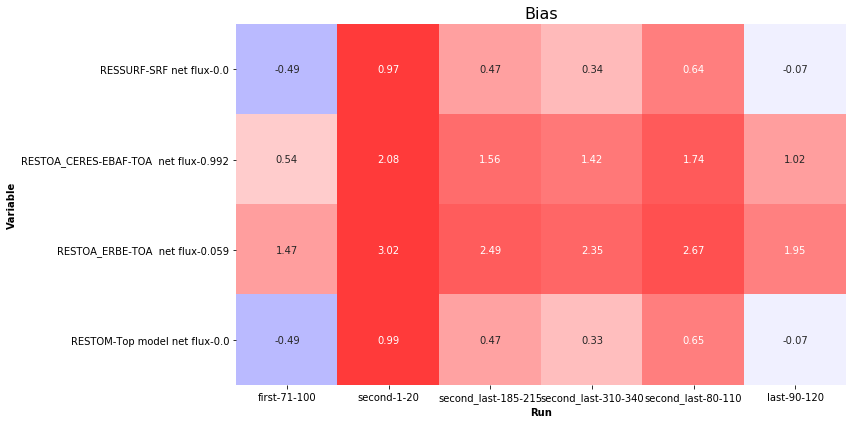

In [25]:
ax = helpers.df_to_heatmap(bias, 
                           center=0, # table value that is mapped to the center of the colormap
                           color_rowwise=1, #apply color mapping rowwise
                           normalise_rows=0, # see next cell for an example
                           table_name="Bias",
                           figsize=FIG_SIZE)
ax.set_xlabel("Run", weight="bold")
ax.set_ylabel("Variable", weight="bold")
ax.figure.tight_layout()
ax.figure.savefig(os.path.join(OUTPUT_DIR, "bias_heatmap.png"))

Now the same but including a rowwise normalisation based on the mean bias in each row.

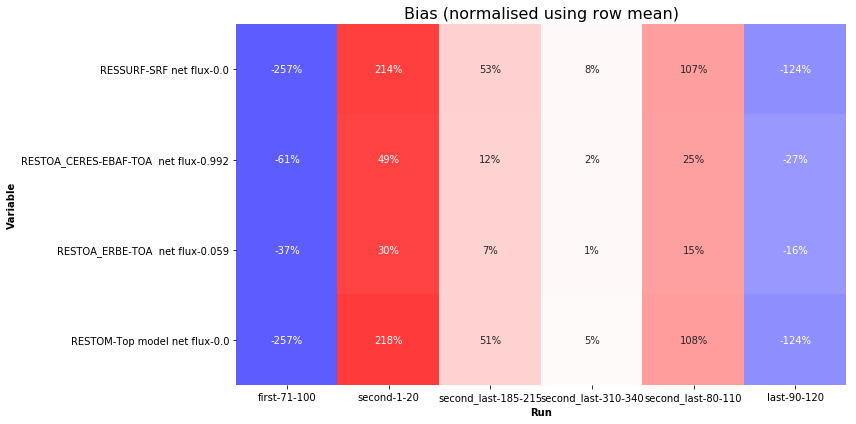

In [26]:
ax = helpers.df_to_heatmap(bias, 
                   center=0, # table value that is mapped to the center of the colormap
                   normalise_rows=1, # perform rowwise normalisation and plot percentage deviation from row mean
                   table_name="Bias",
                   figsize=FIG_SIZE)
ax.set_xlabel("Run", weight="bold")
ax.set_ylabel("Variable", weight="bold")
ax.figure.tight_layout()
ax.figure.savefig(os.path.join(OUTPUT_DIR, "bias_heatmap_deviation_rowmean.png"))

Now the same but including a rowwise normalisation based on the values in the 4th column.

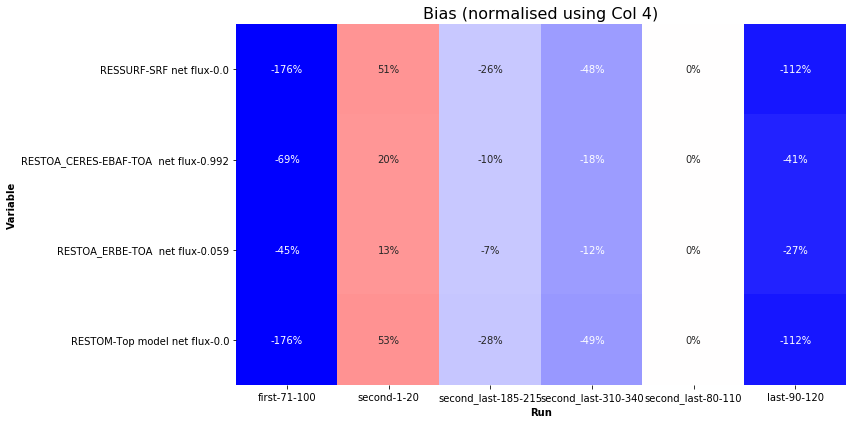

In [27]:
ax = helpers.df_to_heatmap(bias, 
                   center=0, # table value that is mapped to the center of the colormap
                   normalise_rows=1, # perform rowwise normalisation and plot percentage deviation from row mean
                   normalise_rows_col=4,
                   table_name="Bias",
                   figsize=FIG_SIZE)
ax.set_xlabel("Run", weight="bold")
ax.set_ylabel("Variable", weight="bold")
ax.figure.tight_layout()
ax.figure.savefig(os.path.join(OUTPUT_DIR, "bias_heatmap_deviation_rowmean.png"))

#### 7.2. Plot and save RMSE table (2 versions) 

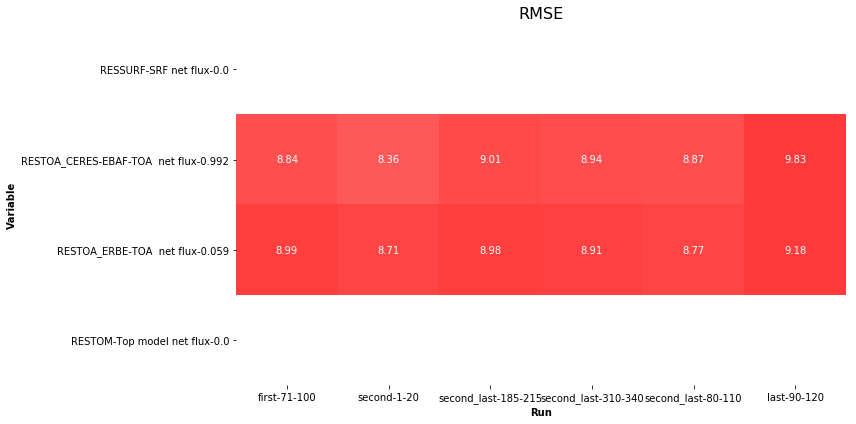

In [28]:
ax = helpers.df_to_heatmap(rmse, 
                   table_name="RMSE",
                   figsize=FIG_SIZE)
ax.set_xlabel("Run", weight="bold")
ax.set_ylabel("Variable", weight="bold")
ax.figure.tight_layout()
ax.figure.savefig(os.path.join(OUTPUT_DIR, "rmse_heatmap.png"))

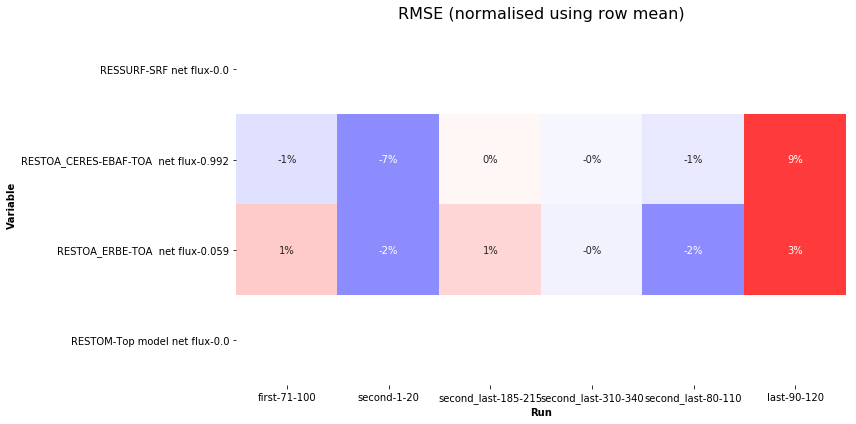

In [29]:
ax = helpers.df_to_heatmap(rmse, 
                   center=0, # table value that is mapped to the center of the colormap
                   normalise_rows=1, # perform rowwise normalisation and plot percentage deviation from row mean
                   table_name="RMSE",
                   figsize=FIG_SIZE)
ax.set_xlabel("Run", weight="bold")
ax.set_ylabel("Variable", weight="bold")
ax.figure.tight_layout()
ax.figure.savefig(os.path.join(OUTPUT_DIR, "rmse_heatmap_deviation_rowmean.png"))

Now the same but including a rowwise normalisation based on the values in the 4th column.

#### 7.2. Plot and save RMSE_ERR table (1 version) 

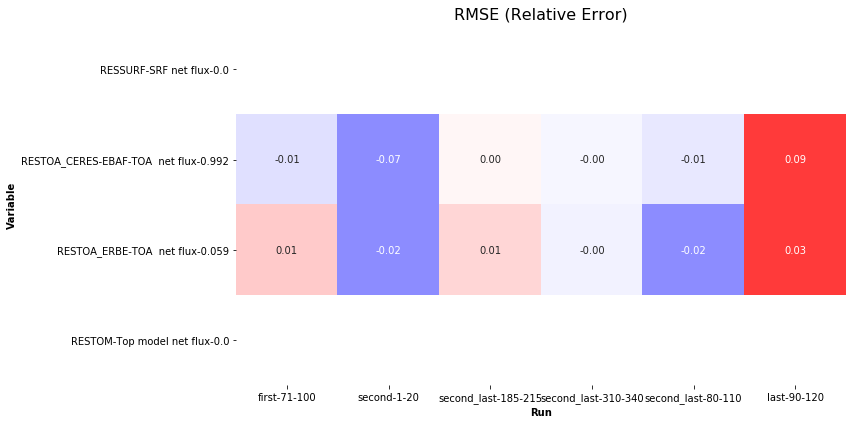

In [30]:
ax = helpers.df_to_heatmap(rmse_err, 
                   table_name="RMSE (Relative Error)",
                   figsize=FIG_SIZE)
ax.set_xlabel("Run", weight="bold")
ax.set_ylabel("Variable", weight="bold")
ax.figure.tight_layout()
ax.figure.savefig(os.path.join(OUTPUT_DIR, "rmse_err_heatmap.png"))

### 8. Concatenate (Bias, RMSE and typical RMSE) and save results as CSV and EXCEL

In the following, the three result tables ``bias``, ``rmse`` and ``rmse_err`` are merged into one result table and then saved both as excel table and as csv file.

In [31]:
import pandas as pd
result = pd.concat([bias, rmse, rmse_err],axis=1, keys=["Bias", "RMSE", "RMSE_ERR"])
result.to_csv('{}/result.csv'.format(OUTPUT_DIR))
result

Bias                             \
Run                                         first second second_last           
Years                                      71-100   1-20     185-215 310-340   
Variable          Description        Obs                                       
RESSURF           SRF net flux       0.000 -0.489  0.974       0.474   0.337   
RESTOA_CERES-EBAF TOA  net flux      0.992  0.537  2.083       1.561   1.420   
RESTOA_ERBE       TOA  net flux      0.059  1.470  3.017       2.494   2.353   
RESTOM            Top model net flux 0.000 -0.489  0.987       0.468   0.327   

                                                           RMSE         \
Run                                                 last  first second   
Years                                      80-110 90-120 71-100   1-20   
Variable          Description        Obs                                 
RESSURF           SRF net flux       0.000  0.643 -0.075    NaN    NaN   
RESTOA_CERES-EBAF TOA  net flux      0.992  1.741  1.021  8.842  8.358   
RESTOA_ERBE       TOA  net flux      0.059  2.674  1.954  8.992  8.706   
RESTOM            Top model net flux 0.000  0.647 -0.075    NaN    NaN   

                                                                              \
Run                                        second_last                  last   
Years                                          185-215 310-340 80-110 90-120   
Variable          Description        Obs                                       
RESSURF           SRF net flux       0.000         NaN     NaN    NaN    NaN   
RESTOA_CERES-EBAF TOA  net flux      0.992       9.011   8.937  8.872  9.827   
RESTOA_ERBE       TOA  net flux      0.059       8.977   8.906  8.772  9.180   
RESTOM            Top model net flux 0.000         NaN     NaN    NaN    NaN   

                                            RMSE_ERR                        \
Run                                            first    second second_last   
Years                                         71-100      1-20     185-215   
Variable          Description        Obs                                     
RESSURF           SRF net flux       0.000       NaN       NaN         NaN   
RESTOA_CERES-EBAF TOA  net flux      0.992 -0.014764 -0.068695    0.004067   
RESTOA_ERBE       TOA  net flux      0.059  0.007827 -0.024228    0.006146   
RESTOM            Top model net flux 0.000       NaN       NaN         NaN   

                                                                          
Run                                                                 last  
Years                                        310-340    80-110    90-120  
Variable          Description        Obs                                  
RESSURF           SRF net flux       0.000       NaN       NaN       NaN  
RESTOA_CERES-EBAF TOA  net flux      0.992 -0.004179 -0.011421  0.094991  
RESTOA_ERBE       TOA  net flux      0.059 -0.001812 -0.016831  0.028898  
RESTOM            Top model net flux 0.000       NaN       NaN       NaN

Now save the table as excel file.

In [32]:
writer = pd.ExcelWriter('{}/result.xlsx'.format(OUTPUT_DIR))
result.to_excel(writer)
writer.save()
writer.close()